In [25]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

Loading BokehJS ...


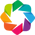

DATE_                GROUPE_ACCIDENT COMMUNE CONDITIONS_LUMINEUSES  \
0 2010-11-30  Dérapage ou perte de maîtrise  Genève                  Nuit   
1 2010-12-08                         Autres  Genève                  Jour   

  CONDITIONS_METEO         CONSEQUENCES    COOR_X     COOR_Y ETAT_ROUTE  \
0   Chute de neige  Avec blessés légers  6.153116  46.200401   Enneigée   
1             Beau               Autres  6.129641  46.206753      Sèche   

        GENRE_ROUTE    ...        DayTime  SEASON  \
0  Route secondaire    ...        Evening  Autumn   
1  Route secondaire    ...      Afternoon  Winter   

                              CAUSE_g  \
0          Inattention et distraction   
1  Utilisation inadéquate du véhicule   

                                     CAUSE_sg  ENFANTS_IMPLIQUES  NB_MOTO  \
0                Manque d'attention momentané                  0      0.0   
1  Stationnement sans précautions suffisantes                  0      0.0   

   NB_BIKE  NB_TPubl  NB_ProfT  NB_LourdT  
0      0.0       0.0       0.0        0.0  
1      0.0       0.0       0.0        0.0  

[2 rows x 44 columns]

In [1]:
# Import common libraries
import pandas as pd
import numpy as np

import holoviews as hv
import geoviews as gv
import geoviews.feature as gf
import cartopy
import shapely as sh
import datashader as ds

from cartopy import crs as ccrs

from bokeh.tile_providers import STAMEN_TONER
from bokeh.models import WMTSTileSource
from bokeh.plotting import figure, output_file, show

from holoviews.operation.datashader import regrid, shade, datashade, dynspread
from bokeh.tile_providers import STAMEN_TONER

import geoviews.feature as gf

from bokeh.io import output_notebook

output_notebook()
hv.notebook_extension('bokeh')

acc_df = pd.read_pickle('./acc_df.pkl', compression='infer')

acc_df.head(2)

In [2]:
mini_df = acc_df[['COOR_X', 'COOR_Y', 'CONDITIONS_LUMINEUSES', 'CONDITIONS_METEO','GROUPE_ACCIDENT','YEAR']]
mini_df.head()

COOR_X     COOR_Y CONDITIONS_LUMINEUSES CONDITIONS_METEO  \
0  6.153116  46.200401                  Nuit   Chute de neige   
1  6.129641  46.206753                  Jour             Beau   
2  6.202445  46.221384                  Jour          Couvert   
3  6.180094  46.208173                  Nuit          Couvert   
4  6.174721  46.199584                  Nuit            Pluie   

                 GROUPE_ACCIDENT  YEAR  
0  Dérapage ou perte de maîtrise  2010  
1                         Autres  2010  
2  Dérapage ou perte de maîtrise  2010  
3             Collision frontale  2010  
4      Accident par tamponnement  2010

## COOL VISUALIZATION OF THE ACCIDENTS IN THE WHOLE CANTON

In [7]:
%%output filename="geneve"
years = list(range(2010,2017))
dictionary = {(year):hv.Points(mini_df[(mini_df.YEAR==year)], ['COOR_X','COOR_Y'])
              for year in years}
hv.Curve((years, [mini_df[mini_df['YEAR']==y].shape[0] for y in years])) + dynspread(datashade(hv.HoloMap(dictionary, kdims=['year']))) 

/Users/Mart/anaconda3/lib/python3.6/site-packages/holoviews/operation/datashader.py:358: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  if 'x_axis' in agg and 'y_axis' in agg:
/Users/Mart/anaconda3/lib/python3.6/site-packages/holoviews/operation/datashader.py:358: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  if 'x_axis' in agg and 'y_axis' in agg:
/Users/Mart/anaconda3/lib/python3.6/site-packages/holoviews/operation/datashader.py:358: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  if 'x_axis' in agg and 'y_axis' in agg:
/Users/Mart/anaconda3/lib/python3.6/site-packages/holoviews/operation/datashader.py:358: FutureWarning: xarray.DataArr

:Layout
   .Curve.I      :Curve   [x]   (y)
   .DynamicMap.I :DynamicMap   [year]

# LET'S GO FOR A DEEPER ANALYSIS OF THE ACCIDENTS IN GENEVE ONLY

In [8]:
lums_ = list(mini_df['CONDITIONS_LUMINEUSES'].value_counts().index)+['ALL']
meteos_ = list(mini_df['CONDITIONS_METEO'].value_counts().index)+['ALL']
jours_ = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi','Vendredi', 'Samedi', 'Dimanche','ALL']

Geneve_df = acc_df[acc_df['COMMUNE']=='Genève'][['GROUPE_ACCIDENT', 'CONDITIONS_LUMINEUSES',
       'CONDITIONS_METEO', 'CONSEQUENCES', 'COOR_X', 'COOR_Y', 'JOUR']]
Geneve_df.reset_index(inplace=True,drop=True)

from pyproj import Proj, transform
# projection definition
p1 = Proj(init='epsg:4326')
p2 = Proj(init='EPSG:3857')

# Helper functions
def coord_proj(acc_df,i, p1, p2):
    x1 = acc_df['COOR_X'].loc[i]
    y1 = acc_df['COOR_Y'].loc[i]
    x2, y2 = transform(p1,p2,x1,y1)
    acc_df['COOR_X'].set_value(i, x2)
    acc_df['COOR_Y'].set_value(i, y2)
    return acc_df

# Project data
for i in range(0, len(Geneve_df['COOR_X'])-1):
    Geneve_df = coord_proj(Geneve_df,i, p1, p2)
Geneve_df.head()

GROUPE_ACCIDENT CONDITIONS_LUMINEUSES CONDITIONS_METEO  \
0    Dérapage ou perte de maîtrise                  Nuit   Chute de neige   
1                           Autres                  Jour             Beau   
2  Accident impliquant des piétons                  Nuit          Couvert   
3    Dérapage ou perte de maîtrise                  Nuit             Beau   
4    Dérapage ou perte de maîtrise                  Nuit   Chute de neige   

          CONSEQUENCES         COOR_X        COOR_Y      JOUR  
0  Avec blessés légers  684961.768030  5.812522e+06     Mardi  
1               Autres  682348.537315  5.813544e+06  Mercredi  
2  Avec blessés graves  682606.654562  5.811554e+06     Mardi  
3               Autres  684923.529555  5.814330e+06  Vendredi  
4               Autres  682272.668087  5.815673e+06  Vendredi

In [9]:
%%output filename="timeseries"
%%opts Overlay [width=600 height=300 xaxis=None yaxis=None show_grid=False ] (background_alpha=1) 
%%opts Shape (fill_color=None line_width=1.5) [apply_ranges=False] 
%%opts Points (size=0.005 cmap='inferno') [apply_ranges=False tools=[]]
%%opts WMTS (alpha=1)



def mini_retrieve_dataset(lum, jour):
    if (lum != 'ALL') & (jour != 'ALL'):
        return Geneve_df[(Geneve_df['CONDITIONS_LUMINEUSES']==lum) & (Geneve_df['JOUR']==jour)]
    if (lum == 'ALL') & (jour == 'ALL'):
        return Geneve_df
    if (lum == 'ALL'):
         return Geneve_df[Geneve_df['JOUR']==jour]
    if (jour == 'ALL'):
         return Geneve_df[Geneve_df['CONDITIONS_LUMINEUSES']==lum]


def timeseries(lum):
    jour_IDS = [1,2,3,4,5,6,7]
    if lum!='ALL':
        return hv.Curve((jour_IDS, [Geneve_df[(Geneve_df['CONDITIONS_LUMINEUSES']==lum) &(Geneve_df['JOUR']==jours_[x-1])].shape[0] for x in jour_IDS]  ))
    return hv.Curve((jour_IDS, [Geneve_df[Geneve_df['JOUR']==jours_[x-1]].shape[0] for x in jour_IDS]))


mini_dictionary = {(lum, jour) : 
              hv.Points( mini_retrieve_dataset(lum, jour), ['COOR_X','COOR_Y'], )
              for lum in lums_
              for jour in jours_}

timeseries_dict = {(lum):timeseries(lum) for lum in lums_}

hv.HoloMap(timeseries_dict, kdims=['condizioni luminose'])+hv.HoloMap(mini_dictionary, kdims=['condizioni luminose','giorno'])

:Layout
   .HoloMap.I  :HoloMap   [condizioni luminose]
      :Curve   [x]   (y)
   .HoloMap.II :HoloMap   [condizioni luminose,giorno]
      :Points   [COOR_X,COOR_Y]   (GROUPE_ACCIDENT,CONDITIONS_LUMINEUSES,CONDITIONS_METEO,CONSEQUENCES,JOUR)

In [14]:
Geneve_df.head()

GROUPE_ACCIDENT CONDITIONS_LUMINEUSES CONDITIONS_METEO  \
0    Dérapage ou perte de maîtrise                  Nuit   Chute de neige   
1                           Autres                  Jour             Beau   
2  Accident impliquant des piétons                  Nuit          Couvert   
3    Dérapage ou perte de maîtrise                  Nuit             Beau   
4    Dérapage ou perte de maîtrise                  Nuit   Chute de neige   

          CONSEQUENCES         COOR_X        COOR_Y      JOUR  
0  Avec blessés légers  684961.768030  5.812522e+06     Mardi  
1               Autres  682348.537315  5.813544e+06  Mercredi  
2  Avec blessés graves  682606.654562  5.811554e+06     Mardi  
3               Autres  684923.529555  5.814330e+06  Vendredi  
4               Autres  682272.668087  5.815673e+06  Vendredi

In [23]:
%%output filename="bpd_datashaded_points"
%%opts Overlay [width=600 height=600 xaxis=None yaxis=None show_grid=False ] (background_alpha=0.1) 
%%opts Shape (fill_color=None line_width=1.5) [apply_ranges=False] 
%%opts Points [tools=['hover'] size_index=2 color_index=2 xaxis=None yaxis=None]
%%opts WMTS (alpha=0.05)

geourl = 'https://cartodb-basemaps-{s}.global.ssl.fastly.net/light_all/{z}/{x}/{y}.png'
geomap = gv.WMTS(WMTSTileSource(url='https://maps.wikimedia.org/osm-intl/{Z}/{X}/{Y}@2x.png'))
#geomap = gv.WMTS(tiles['Stamen Toner'])

geomap*dynspread(datashade(hv.HoloMap(mini_dictionary, kdims=['condizioni luminose','giorno'])))


/Users/Mart/anaconda3/lib/python3.6/site-packages/holoviews/operation/datashader.py:358: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  if 'x_axis' in agg and 'y_axis' in agg:
/Users/Mart/anaconda3/lib/python3.6/site-packages/holoviews/operation/datashader.py:358: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  if 'x_axis' in agg and 'y_axis' in agg:
/Users/Mart/anaconda3/lib/python3.6/site-packages/holoviews/operation/datashader.py:358: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  if 'x_axis' in agg and 'y_axis' in agg:
/Users/Mart/anaconda3/lib/python3.6/site-packages/holoviews/operation/datashader.py:358: FutureWarning: xarray.DataArr

:DynamicMap   [condizioni luminose,giorno]